# Sparse coding (Olshausen & Field, 1996)
This notebook describes the model for sparse coding in vision (Olshausen & Field, Nature. 1996) and implements it in Python. ([Olshausen & Field, *Nature*. 1996](https://www.nature.com/articles/381607a0))

#sparse coding
Image  $\boldsymbol{I} (\boldsymbol{x})$ is the basis function $\Phi = [\phi_i(\boldsymbol{x})]$ linear sum of (The coefficient is $\boldsymbol{r}=[r_i] $)Suppose it is expressed as。

$$
\boldsymbol{I}(\boldsymbol{x}) = \sum_i r_i \phi_i (\boldsymbol{x}) + \epsilon(\boldsymbol{x})= \Phi \boldsymbol{r} + \epsilon(\boldsymbol{x})
\tag{1}
$$

However, $\boldsymbol{x}$ is the coordinate on the image, $\epsilon$ represents Gaussian noise with 0 mean. Also,$\boldsymbol{r}$. Let be the activity of higher-order neurons than the input, and $\Phi$ be the weight matrix.

Sparse coding aims to represent an image (or objective variable) with a small number of bases. The point is that we want to find the sparse coefficient $\boldsymbol{r}$ in equation (1), where most of the coefficients are 0 and only some of them take values ​​other than 0. Please note that sparse coding is a term commonly used in statistics and machine learning.

## Setting the objective function
The objective function (cost function) $E$ for sparse coding is as shown in equation (2).

$$
E = \underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(\frac{r_i}{\sigma}\right)}_{\text{sparseness of}\ r_i} \tag{2}
$$

However, $\lambda$ is a regularization coefficient and $\sigma$ is a scaling constant. Here, the first term is the restoration loss, and the second term is the penalty term (a term that prevents the coefficient from becoming a large value).

$S(x)$ Functions such as $-\exp(-x^2), \ln(1+x^2), |x|$ are used as such. These functions have a pointed shape at the origin, making it easy for the solution to be 0. When drawn, it will look like this: However, to adjust the scale, $1$ was added to $-\exp(-x^2)$.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io as sio
import cv2

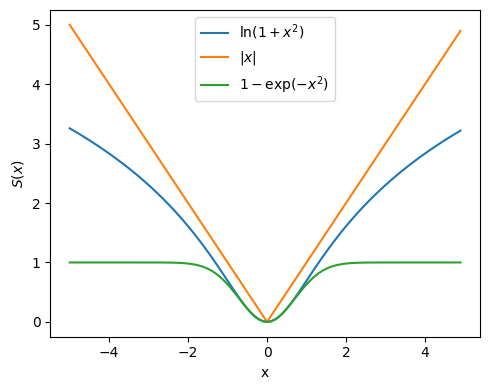

In [34]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.1)

plt.figure(figsize=(5,4))
plt.plot(x, np.log(1+x**2), label=r"$\ln(1+x^2)$")
plt.plot(x, np.abs(x), label=r"$|x|$")
plt.plot(x, 1-np.exp(-x**2), label=r"$1-\exp(-x^2)$")
plt.xlabel("x")
plt.ylabel(r"$S(x)$")
plt.legend()
plt.tight_layout()
plt.show()

From the next section, we will explain how to obtain the optimal $\boldsymbol{r}$ and $\Phi$ based on sparse coding.

##  Locally Competitive Algorithm (LCA)
$\boldsymbol{r}$ The update rule using the gradient method for is obtained by differentiating the objective function $E$ as follows.

$$
\begin{aligned}
\frac{d \boldsymbol{r}}{dt} &= -\frac{\eta_\boldsymbol{r}}{2}\frac{\partial E}{\partial \boldsymbol{r}}\\
&=\eta_\boldsymbol{r} \cdot\left[\Phi^T (\boldsymbol{I}-\Phi\boldsymbol{r})- \frac{\lambda}{2\sigma}S'\left(\frac{r_i}{\sigma}\right)\right]
\end{aligned}\tag{3}
$$

where $\eta_{\boldsymbol{r}}$ is the learning rate. This formula optimizes $\boldsymbol{r}$ until it converges, but instead of using a simple gradient method, (Olshausen & Field, 1996) uses the conjugate gradient method. However, since the conjugate gradient method is complicated and inefficient to implement, **LCA** (locally competitive algorithm) has been proposed as a more efficient and physiologically valid learning method ([Rozell et al. al., *Neural Comput*. 2008](https://www.ece.rice.edu/~eld1/papers/Rozell08.pdf)). LCA is an updating law that uses **local competition, lateral inhibition** and **thresholding function**. Unlike regular RNNs, RNNs that update using LCA are dynamic systems that minimize the cost function (or energy function). Olshausen calls this mechanism "the Hopfield trick" because it is used in the Hopfield network.

### When using a soft threshold function (ISTA)
$S(x)=|x|$ **ISTA** (Iterative Shrinkage Thresholding Algorithm) is a method that uses a threshold function in this case. ISTA is a proximal gradient method for the L1-norm regularization term, and is essentially a gradient method used for Lasso regression.

The problem to be solved is expressed by equation (4).

$$
\boldsymbol{r} = \mathop{\rm arg~min}\limits_{\boldsymbol{r}}\left\{\|\boldsymbol{I}-\Phi\boldsymbol{r}\|^2_2+\lambda\|\boldsymbol{r}\|_1\right\}\tag{4}
$$

The details will be explained later, but the solution can be obtained by updating as follows.

1. $\boldsymbol{r}(0)$ Initialize with a vector with all 0 elements
2. $\boldsymbol{r}_*(t+1)=\boldsymbol{r}(t)+\eta_\boldsymbol{r}\cdot \Phi^T(\boldsymbol{I}-\Phi\boldsymbol{r}(t))$
3. $\boldsymbol{r}(t+1) = S_\lambda(\boldsymbol{r}_*(t+1))$
4. $\boldsymbol{r}$ Repeat steps 2 and 3 until convergence

here $S_\lambda(\cdot)$ is a **soft decision threshold function** (Soft thresholding function) It is called and expressed by equation (5).

$$
S_\lambda(y)=
\begin{cases}
y-\lambda & (y>\lambda)\\
0 & (-\lambda\leq y\leq\lambda)\\
 y+\lambda & (y<-\lambda)
\end{cases}\tag{5}
$$

$S_\lambda(\cdot)$ When drawn, it looks like this:

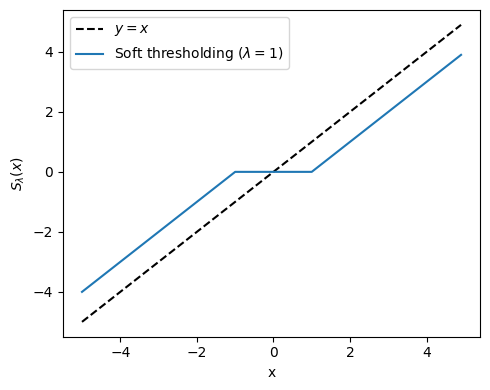

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# thresholding function of S(x)=|x|
def soft_thresholding_func(x, lmda):
    return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

plt.figure(figsize=(5,4))
x = np.arange(-5, 5, 0.1)
y = soft_thresholding_func(x, 1)
plt.plot(x, x, "k--", label=r"$y=x$")
plt.plot(x, y, label=r"Soft thresholding ($\lambda=1$)")
plt.xlabel("x")
plt.ylabel(r"$S_\lambda (x)$")
plt.legend()
plt.tight_layout()
plt.show()

The soft thresholding function can be derived by finding $x$ that minimizes the following objective function $C$.

$$
C=\frac{1}{2}(y-x)^2+\lambda |x| \tag{6}
$$

However, assume that $x, y, and \lambda$ are scalar values. $|x|$ cannot be differentiated, but this can be solved by considering cases. Considering $x\geq 0$, equation (6) becomes

$$
C=\frac{1}{2}(y-x)^2+\lambda x = \{x-(y-\lambda)\}^2+\lambda(y-\lambda) \tag{7}
$$

It becomes. Here, $x$ that gives the minimum value in equation (7) is considered in different cases as follows:
When $y-\lambda\geq 0$, consider the vertices of the quadratic function and get $x=y-\lambda$. On the other hand, when $y-\lambda<0$, it becomes a monotonically increasing function at $x\geq 0$, so the minimum is when $x=0$. By conducting the same argument for $x\leq 0$, we obtain equation (5).

### CauchyWhen using a distribution threshold function
Next, consider the case using $S(x)=\ln(1+x^2)$. This converts the Cauchy distribution into the prior distribution of $\boldsymbol{r}$ $p(\boldsymbol{r})=\prod_i p(r_i)=\prod_i \exp\left[-\alpha \ln(1+r_i^2 )\right]$, the negative logarithmic prior distribution $g(\boldsymbol{r}):=-\ln p(\boldsymbol{r})=\alpha \sum_i \ln(1+r_i^2) It corresponds to $.

As in the previous section, find $x$ that minimizes the one-dimensional objective function $C$, expressed by the following equation.

$$
C=(y-x)^2+\lambda \ln(1+x^2) \tag{8}
$$

This time, since it is differentiable, find $x$ such that the slope of equation (8) is 0.

$$
\frac{\partial C}{\partial x}=-2(y-x)+\frac{2\lambda x}{1+x^2} \tag{9}
$$

(9) I would like to organize $x$ by setting the formula $=0$, but first, let's solve for $y$.

$$
y=x+\frac{\lambda x}{1+x^2} \tag{10}
$$

It becomes. All that's left to do is find the inverse function of equation (10), but it's complicated no matter how you look at it, so let's use Wolfram alpha ([Result] (https://ja.wolframalpha.com/input/?i=y%3Dax%2F%281%2Bx%5E2%29%2Bx%E3%81%AE%E9%80%86%E9%96%A2%E6%95%B0))。When the solution is rearranged, it is expressed as equation (11).

$$
\begin{aligned}
S_\lambda(y)&=\frac{1}{3}\left[y-\frac{h_\lambda(y)}{\sqrt[3]{2}}+\frac{\sqrt[3]{2} \cdot g_\lambda(y)}{h_\lambda(y)}\right]\\
f_\lambda(y) &:= 9\lambda y - 2y^3-18y\\
g_\lambda(y) &:= 3\lambda - y^2+3\\
h_\lambda(y) &:= \left[\sqrt{f_\lambda(y)^2+4g_\lambda(y)^3}+f_\lambda(y)\right]^\frac{1}{3}
\end{aligned}\tag{11}
$$

(11)When you implement the formula, it looks like this:

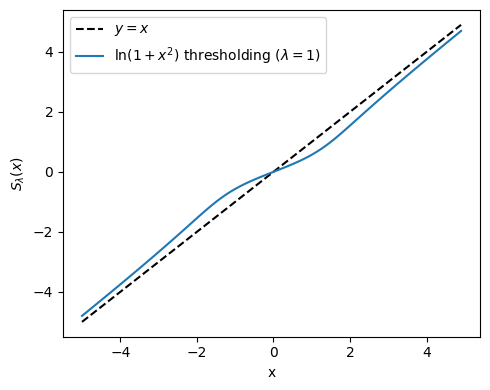

In [ ]:
# thresholding function of S(x)=ln(1+x^2)
def ln_thresholding_func(x, lmda):
    f = 9*lmda*x - 2*np.power(x, 3) - 18*x
    g = 3*lmda - np.square(x) + 3
    h = np.cbrt(np.sqrt(np.square(f) + 4*np.power(g, 3)) + f)
    two_croot = np.cbrt(2) # cubic root of two
    return (1/3)*(x - h / two_croot + two_croot*g / (1e-8+h))

plt.figure(figsize=(5,4))
x = np.arange(-5, 5, 0.1)
y = ln_thresholding_func(x, 1)
plt.plot(x, x, "k--", label=r"$y=x$")
plt.plot(x, y, label=r"$\ln(1+x^2)$ thresholding ($\lambda=1$)")
plt.xlabel("x")
plt.ylabel(r"$S_\lambda (x)$")
plt.legend()
plt.tight_layout()
plt.show()

Soft thresholding You can see that the shape resembles a relaxed function. However, even if I used this as is, I could not obtain a sparse representation (maybe due to insufficient adjustment of the hyperparameters). Therefore, ([Mayo et al., arXiv. 2020](https://arxiv.org/abs/2003.12507)) Let's use the **Cauchy thresholding** function proposed in .

Cauchy thresholding The function is expressed as:

$$
S_\lambda(y)=
\begin{cases}
\dfrac{1}{2}\left(y+\sqrt{y^2-4\lambda}\right) & (y>2\lambda)\\
0 & (-2\lambda\leq y\leq 2\lambda)\\
\dfrac{1}{2}\left(y-\sqrt{y^2-4\lambda}\right) & (y<-2\lambda)
\end{cases}\tag{12}
$$

The implementation looks like this:

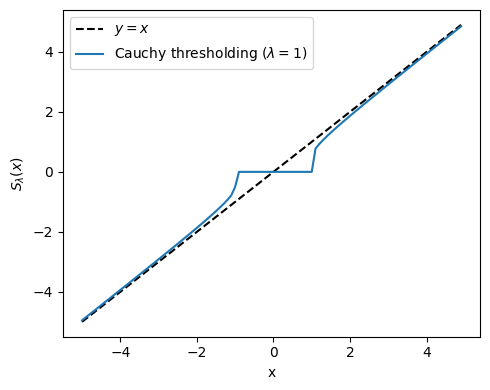

In [ ]:
def cauchy_thresholding_func(x, lmda):
    f = 0.5*(x + np.sqrt(np.maximum(x**2 - lmda,0)))
    g = 0.5*(x - np.sqrt(np.maximum(x**2 - lmda,0)))
    return f*(x>=lmda) + g*(x<=-lmda)

plt.figure(figsize=(5,4))
x = np.arange(-5, 5, 0.1)
ln_thresholding_func
y = cauchy_thresholding_func(x, 1)
plt.plot(x, x, "k--", label=r"$y=x$")
plt.plot(x, y, label=r"Cauchy thresholding ($\lambda=1$)")
plt.xlabel("x")
plt.ylabel(r"$S_\lambda (x)$")
plt.legend()
plt.tight_layout()
plt.show()

# You can see that it has a shape similar to a hard thresholding function.

## Weight matrix update rule
$\boldsymbol{r}$Once converged, $\Phi$ is updated using the gradient method.

$$
\begin{aligned}
\Delta \phi_i(\boldsymbol{x}) &= -\eta \frac{\partial E}{\partial \Phi}\\
&=\eta\cdot\left[\left([\boldsymbol{I}-\Phi\boldsymbol{r}\right)\boldsymbol{r}^T\right]
\end{aligned}\tag{13}
$$

## Sparse coding network implementation
### Network structure
It has a simple structure of 2 layers including the input layer. This time, the input is a randomly extracted 16 x 16 (=256) image patch, which is received by 256 neurons in the input layer. Suppose that neurons in the input layer project to 100 neurons in the next layer. Optimize its activity and weight matrix so that 100 neurons encode the input sparsely. The figure below shows the structure of the network. However, $a_i$ corresponds to $r_i$ in this article.

<img src=https://raw.githubusercontent.com/Salad-bowl-of-knowledge/hp/master/_notebooks/images/sparse-coding_figs/fig2a.JPG width=500px>
<div style="text-align: right;"> (Olshausen, 2002; Fig. 2a)</div>

### import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import network
from tqdm.notebook import tqdm
import scipy.io as sio

np.random.seed(0)

### Loading image data
Data is <http://www.rctn.org/bruno/sparsenet/>It can be downloaded from. You can also download the MATLAB code, but I was unable to run it at hand.`IMAGES.mat` contains 10 whitened natural images. For drawing images etc. [Predictive coding (Rao & Ballard, 1999) Implementing the model](https://salad-bowl-of-knowledge.github.io/hp/neuroscience/2020/04/25/predictive-coding.html) Pls refer to

In [ ]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('datasets/IMAGES.mat')
imgs = mat_images['IMAGES']

### Network implementation
Implement the network based on LCA. Basically, we execute the `__call__` function to update the coefficient `r` and the weight matrix `Phi`. Call it externally, update `r` until it converges, then set `training` to `True` and update `Phi`. Also, three threshold functions can be used: `soft_thresholding_func`, `ln_thresholding_func`, and `cauchy_thresholding_func`. Please change which one to use by uncommenting it.

In [ ]:
class OlshausenField1996Model:
    def __init__(self, num_inputs, num_units, batch_size,
                 lr_r=1e-2, lr_Phi=1e-2, lmda=5e-3):
        self.lr_r = lr_r # learning rate of r
        self.lr_Phi = lr_Phi # learning rate of Phi
        self.lmda = lmda # regularization parameter

        self.num_inputs = num_inputs
        self.num_units = num_units
        self.batch_size = batch_size

        # Weights
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1/self.num_units)

        # activity of neurons
        self.r = np.zeros((self.batch_size, self.num_units))

    def initialize_states(self):
        self.r = np.zeros((self.batch_size, self.num_units))

    def normalize_rows(self):
        self.Phi = self.Phi / np.maximum(np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8)

    # thresholding function of S(x)=|x|
    def soft_thresholding_func(self, x, lmda):
        return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

    # thresholding function of S(x)=ln(1+x^2)
    def ln_thresholding_func(self, x, lmda):
        f = 9*lmda*x - 2*np.power(x, 3) - 18*x
        g = 3*lmda - np.square(x) + 3
        h = np.cbrt(np.sqrt(np.square(f) + 4*np.power(g, 3)) + f)
        two_croot = np.cbrt(2) # cubic root of two
        return (1/3)*(x - h / two_croot + two_croot*g / (1e-8+h))

    # thresholding function https://arxiv.org/abs/2003.12507
    def cauchy_thresholding_func(self, x, lmda):
        f = 0.5*(x + np.sqrt(np.maximum(x**2 - lmda,0)))
        g = 0.5*(x - np.sqrt(np.maximum(x**2 - lmda,0)))
        return f*(x>=lmda) + g*(x<=-lmda)

    def calculate_total_error(self, error):
        recon_error = np.mean(error**2)
        sparsity_r = self.lmda*np.mean(np.abs(self.r))
        return recon_error + sparsity_r

    def __call__(self, inputs, training=True):
        # Updates
        error = inputs - self.r @ self.Phi.T

        r = self.r + self.lr_r * error @ self.Phi
        self.r = self.soft_thresholding_func(r, self.lmda)
        #self.r = self.cauchy_thresholding_func(r, self.lmda)

        if training:
            error = inputs - self.r @ self.Phi.T
            dPhi = error.T @ self.r
            self.Phi += self.lr_Phi * dPhi

        return error, self.r

### Defining the model

Define the network implemented above as `model`. Also, initialize the constants used in the simulation.

In [ ]:
# Simulation constants
H, W, num_images = imgs.shape
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)

eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors

# Define model
model = OlshausenField1996Model(num_inputs=sz**2, num_units=num_units,
                                batch_size=batch_size)

**bold text**### Run the simulation
Run the simulation. The outer `for loop` creates an image patch and initializes `r`. The inner `for loop` updates `r` until it converges, and then updates the weight matrix `Phi`.

In [ ]:
# Run simulation
for iter_ in tqdm(range(num_iter)):
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-sz, batch_size)
    beginy = np.random.randint(0, H-sz, batch_size)

    inputs_list = []

    # Get images randomly
    for i in range(batch_size):
        idx = np.random.randint(0, num_images)
        img = imgs[:, :, idx]
        clop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
        inputs_list.append(clop - np.mean(clop))

    inputs = np.array(inputs_list) # Input image patches

    model.initialize_states() # Reset states
    model.normalize_rows() # Normalize weights

    # Input an image patch until latent variables are converged
    r_tm1 = model.r # set previous r (t minus 1)

    for t in range(nt_max):
        # Update r without update weights
        error, r = model(inputs, training=False)
        dr = r - r_tm1

        # Compute norm of r
        dr_norm = np.linalg.norm(dr, ord=2) / (eps + np.linalg.norm(r_tm1, ord=2))
        r_tm1 = r # update r_tm1

        # Check convergence of r, then update weights
        if dr_norm < eps:
            error, r = model(inputs, training=True)
            break

        # If failure to convergence, break and print error
        if t >= nt_max-2:
            print("Error at patch:", iter_)
            print(dr_norm)
            break

    error_list.append(model.calculate_total_error(error)) # Append errors

    # Print moving average error
    if iter_ % 100 == 99:
        print("iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:",
              np.mean(error_list[iter_-99:iter_]))

  0%|          | 0/500 [00:00<?, ?it/s]

iter: 100/500, Moving error: 0.053763300955991876
iter: 200/500, Moving error: 0.049364071115642096
iter: 300/500, Moving error: 0.04899764202648089
iter: 400/500, Moving error: 0.04885324009619198
iter: 500/500, Moving error: 0.04789606380023766


### Drawing losses during training

Let's plot the change in loss during training. You can see that the loss has decreased and learning has progressed.

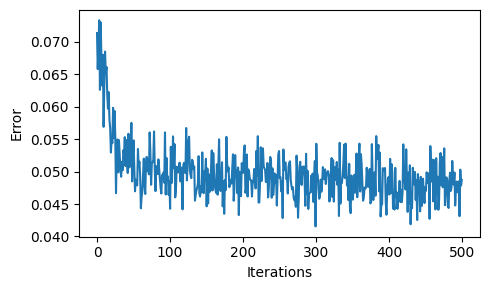

In [ ]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.show()

bold text### Drawing weight matrix (receptive field)
Let's visualize the weight matrix `Phi` ($\Phi$) after learning.

  0%|          | 0/100 [00:00<?, ?it/s]

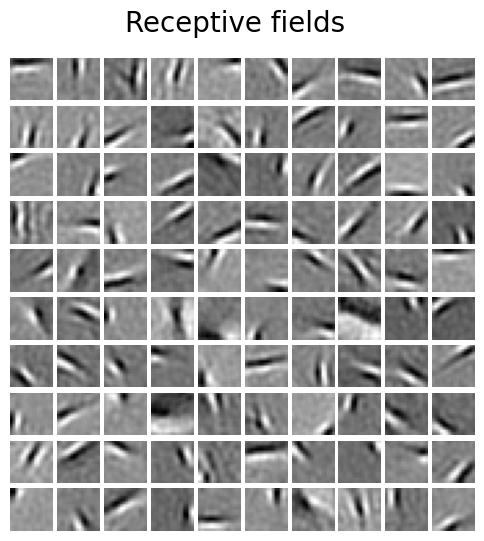

In [ ]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(num_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

White represents the **ON area** (excitation), and black represents the **OFF area** (inhibition). Gabor filter-like local reception

This field is similar to the receptive field of simple cells in the primary visual cortex (V1).

I am.
In addition, using `cauchy_thresholding_func` and setting `lmda=1e-3`, the result is as shown in the following figure.

<img src=https://raw.githubusercontent.com/Salad-bowl-of-knowledge/hp/master/_notebooks/images/sparse-coding_figs/RF_cauchy_thresholding.png width=500px>

## ICA and PCA Analysis of natural images by
For reference, let's run ICA and PCA on a natural image. Performing ICA is the same as doing Sparse coding, resulting in a Gabor filter-like local receptive field. On the other hand, performing PCA only yields a wide receptive field.  ([Sanger TD, 1989](https://papers.nips.cc/paper/139-an-optimality-principle-for-unsupervised-learning))。

### import
`sklearn.decomposition`has

In [ ]:
from sklearn.decomposition import FastICA, PCA

### Creating an image patch
The PCA results are better if you use the image before whitening.

In [ ]:
mat_images_raw = sio.loadmat('datasets/IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

# Simulation constants
H, W, num_images = imgs_raw.shape

num_patches = 15000
patchs_list = []
w, h = 16, 16 # patch size

# generate patches
for i in tqdm(range(num_patches)):
    i = np.random.randint(0, num_images)
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-w-1)
    beginy = np.random.randint(0, H-h-1)
    img_clopped = imgs_raw[beginy:beginy+h, beginx:beginx+w, i]
    patchs_list.append(img_clopped.flatten())

patches = np.array(patchs_list)

  0%|          | 0/15000 [00:00<?, ?it/s]

*italicized text*### ICA execution of

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

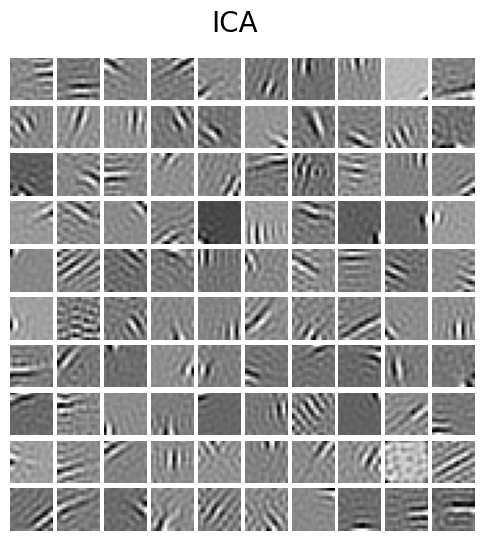

In [ ]:
# perform ICA
n_comp = 100
ica = FastICA(n_components=n_comp)
ica.fit(patches)
ica_filters = ica.components_

# plot filters
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(ica_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("ICA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

Alternatively, you can also obtain a Gabor filter using the K-means method.
- [Gabors / Primary Visual Cortex “Simple Cells” from an Image — skimage v0.13.1 docs](https://scikit-image.org/docs/0.13.x/auto_examples/features_detection/plot_gabors_from_astronaut.html#sphx-glr-auto-examples-features-detection-plot-gabors-from-astronaut-py)

### PCA execution of

In [ ]:
# perform PCA
pca = PCA(n_components=n_comp)
pca.fit(patches)
pca_filters = pca.components_

# plot filters
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(pca_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("PCA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

## summary
- Sparse coding implemented the model.
- LCA (locally competitive algorithm) is a method to efficiently implement sparse coding with a neural network.

- Sparce coding A Gabor filter similar to that of the simple type cell of V1 is obtained.
- In the brain, regularization by suppressing firing, etc. sparse coding It is considered that this has been realized.

### References
- Olshausen BA, Field DJ. [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://www.nature.com/articles/381607a0). *Nature*. 1996;381(6583):607–609. [Data and Code](http://www.rctn.org/bruno/sparsenet/), [pdf](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf)
- Olshausen BA. [Principles of Image Representation in Visual Cortex](https://groups.oist.jp/sites/default/files/img/ocnc/2004/Olshausen.pdf). *The Visual Neurosciences*. 2002.
- Rozell CJ, Johnson DH, Baraniuk RG, Olshausen BA. [Sparse coding via thresholding and local competition in neural circuits](http://www.mit.edu/~9.54/fall14/Classes/class07/Palm.pdf). *Neural Comput*. 2008;20(10):2526‐2563.
- Mayo P, Holmes R, Achim A. [Iterative Cauchy Thresholding: Regularisation with a heavy-tailed prior](https://arxiv.org/abs/2003.12507). arXiv. 2020.
- Paiton DM. [Analysis and applications of the Locally Competitive Algorithm](https://escholarship.org/uc/item/1wz289gt). UC Berkeley. 2019.

### Followed a link from GitHub
- https://github.com/lpjiang97/sparse-coding

### Olshausen teacher's lecture
- [Bruno Olshausen: “Sparse coding in brains and machines”(Stanford talks)](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)

### sparse modeling
- [Sparse modeling you can start doing today](http://www-adsys.sys.i.kyoto-u.ac.jp/mohzeki/Presentation/lecturenote20150909.pdf)
- [I started sparse modeling from the very beginning. (Implemented ISTA) - MAEA2’s diary](http://maea2.hatenablog.com/entry/2017/03/06/235519)